In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from osgeo import gdal

from nansat import Nansat, Domain, NSR

from sea_ice_drift.lib import get_spatial_mean, get_uint8_image

import xarray as xr

import csv

#### Importing data

##### 1) Importing drift algorithm SAR1 - SAR2 parametrs

In [19]:
# Importing drift algorithm SAR1 - SAR2 parametrs

%store -r upm
%store -r vpm
%store -r apm
%store -r rpm
%store -r hpm
%store -r lon2pm
%store -r lat2pm
%store -r lon1pm
%store -r lat1pm

%store -r total_time_diff

##### 2) Importing model drift data


In [11]:
# Importing model drift data

cum_drift_path = r'/home/jovyan/data/model_data_process_output/for_comparison_lambert/total_model_displacement_20221119T07-20221120T09.csv'

with open(cum_drift_path) as csvfile:
    csvreader = csv.reader(csvfile)
    # check if the file has a header row
    has_header = csv.Sniffer().has_header(csvfile.read(1024))
    csvfile.seek(0)  # reset file pointer
    #skip header row if it exists
    if has_header:
        next(csvreader)
    displacements = np.array([row for row in csvreader]).astype(float)

# Import lon, lat, dx, dy
lon_mod, lat_mod = displacements[:, [0]] , displacements[:, [1]] 
dx_mod, dy_mod = displacements[:, [2]] , displacements[:, [3]] 
# Reshape lon, lat, dx, dy to grid shape
dx_mod = dx_mod.reshape(upm.shape)
dy_mod = dy_mod.reshape(upm.shape) 

##### 3) Import model subset grid parameters, concentration and projection

In [40]:
%store -r r
%store -r c
%store -r X_subset
%store -r Y_subset
%store -r lat_subset
%store -r lon_subset
# Import model proj4 file with information about orijection
%store -r proj4

# Import time-period of the forecast subset concentration variable for its start
%store -r time_period
%store -r siconc_subset

# Set up coordinates in meters for visualizing the pattern matching results.
x1pm, y1pm = np.meshgrid(X_subset, Y_subset)

##### 4) Getting land mask

In [38]:
# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

##### 5) Importing SAR data

In [ ]:
# Import SAR data 

# Download arrays

f1 = gdal.Open(r'/home/jovyan/data/SAR_images/subset_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif')
f2 = gdal.Open(r'/home/jovyan/data/SAR_images/subset_of_S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV.tif')
f3 = gdal.Open(r'/home/jovyan/data/SAR_images_forecast/Forecasted_20221119T08_subset_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif')

#Load the data from the files into numpy arrays for further processing.
a1 = f1.ReadAsArray() 
a2 = f2.ReadAsArray()
a3 = f3.ReadAsArray()

#Pre-process images to ensure consistent visualization and handle blank spots issue after pattern patching.

a1 = get_uint8_image(a1, None, None, 1, 99)
a2 = get_uint8_image(a2, None, None, 1, 99)
a3 = get_uint8_image(a3, None, None, 1, 99)

# Create three Nansat objects with original tiff georeference imported from gdal object.
srs_tiff = f1.GetSpatialRef() 

rows, cols = a1.shape
d_sar = Domain(srs_tiff, ds=f1)
n1 = Nansat.from_domain(d_sar, a1)
n2 = Nansat.from_domain(d_sar, a2)
n3 = Nansat.from_domain(d_sar, a3)

# Close the dataset
f1 = None
f2 = None
f3 = None

VMIN:  0.0
VMAX:  0.02111507551744582
VMIN:  0.0
VMAX:  0.02747284863144156
VMIN:  0.0006377207930199802
VMAX:  0.02119946330785752


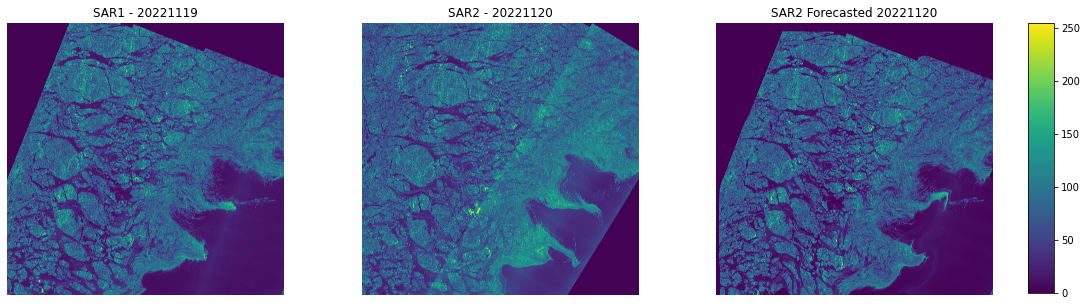

In [ ]:
#Plot
fig, ax = plt.subplots(1,3, figsize=(18,5))
im1 = ax[0].imshow(a1, clim=[0, 255])
ax[0].axis('off')
#plt.colorbar(im0, ax=ax[0])
im2 = ax[1].imshow(a2, clim=[0, 255])
ax[1].axis('off')
#plt.colorbar(im1, ax=ax[1])
im3 = ax[2].imshow(a3, clim=[0, 255])
ax[2].axis('off')
cax = fig.add_axes([0.92, 0.13, 0.02, 0.75])  # Position and size of the colorbar
cbar = fig.colorbar(im3, cax=cax)
#plt.colorbar(im3, ax=ax[2])

ax[0].set_title("SAR1 - 20221119")
ax[1].set_title("SAR2 - 20221120")
ax[2].set_title("SAR2 Forecasted 20221120")

plt.show()

#### Comparison of SAR1 - SAR2 reference drift and model drift

In [33]:
# Convert the proj4 string to a Nansat spatial reference object
srs = NSR(proj4)

# model domain to reproject SAR image from 3996
model_d = Domain(srs, f'-te {min(X_subset.data)} {min(Y_subset.data)} {max(X_subset.data)} {max(Y_subset.data)} -tr 100 100')
# reproject n1 for visualizing SAR image in the same projection as model data
n1.reproject(model_d)

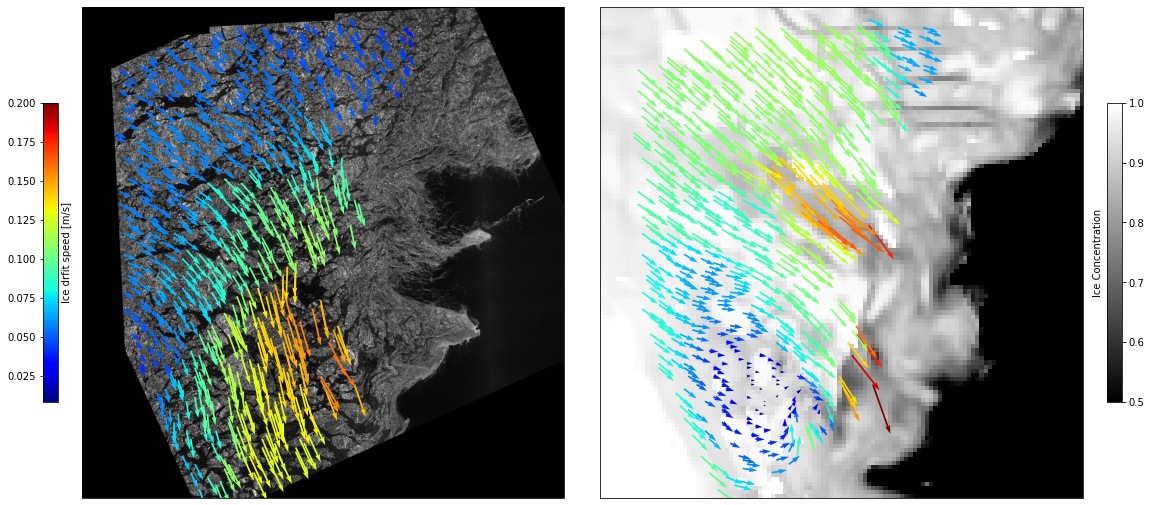

In [52]:
#dayssec = 24*60*60
dayssec = total_time_diff

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt((v**2+u**2)) 
# compute model ice drift speed [m/s]
delta_t = dayssec #in seconds
u_model = dx_mod / delta_t
v_model = dy_mod / delta_t
speed_model = np.sqrt((v_model**2+u_model**2)) 

gpi = (hpm > 9)*(siconc_subset > 0.5)

# Combined data range
all_speeds = np.concatenate([speed[gpi], speed_model[gpi]])
vmin, vmax = np.min(all_speeds), np.max(all_speeds)
# Use this range to normalize both datasets
#norm = Normalize(vmin=vmin, vmax=vmax)
norm = Normalize(vmin=vmin, vmax=0.2)

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,11), subplot_kw={'projection': crs})

# Figure 1

ax1.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
# Overlay a semi-transparent gray layer
#gray_value = 0.9 # Midway between 0 (black) and 1 (white)
#rect = Rectangle((x1pm.min(), y1pm.min()), x1pm.max() - x1pm.min(), y1pm.max() - y1pm.min(), facecolor='black', alpha=0.4) #facecolor = str(gray_value)
#ax1.add_patch(rect)

# plot every n_th vector
quiv1=ax1.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6],speed[gpi][::6], scale=2, cmap='jet',width=0.0035, norm = norm)
#quiv1=ax1.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1],speed[gpi][::1], scale=2, cmap='jet',width=0.0035,  norm = norm) 
#quiv1=ax1.quiver(x1pm[::1], y1pm[::1], u[::1], v[::1],speed[::1], scale=2, cmap='jet',width=0.0035,  norm = norm) 
plt.quiverkey(quiv1, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
#plt.title('Ice drfit speed [m/s]')
ax1.add_feature(land_50m, edgecolor='black')
ax1.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax1.set_ylim([y1pm.min()+30000, y1pm.max()-60000])

#  Figure 2

# plot concentration
conc_img = ax2.imshow(siconc_subset, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='gray', alpha=1, vmin=0.5, vmax=1)
#plot every n_th vector
quiv2 = ax2.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u_model[gpi][::6], v_model[gpi][::6], speed_model[gpi][::6], scale=2, cmap='jet', width=0.0035, norm=norm)
#quiv2 = ax2.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u_model[gpi][::1], v_model[gpi][::1], speed_model[gpi][::1], scale=2, cmap='jet', width=0.0035, norm=norm)
#quiv2 = ax2.quiver(x1pm[::1], y1pm[::1], u_model[::1], v_model[::1], speed_model[::1], scale=2, cmap='jet', width=0.0035, norm=norm)
plt.quiverkey(quiv2, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
#plt.title('Ice drfit speed [m/s]')
ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax2.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
# colorbar for the concentration



#plt.colorbar(quiv1, ax=ax1, orientation='vertical', shrink=0.5)
cbar1 = plt.colorbar(quiv1,ax=ax1, label='Ice drfit speed [m/s]', location='left', shrink=0.5, pad=0.04)
cbar1.ax.yaxis.set_label_position('right')

cbar2 = plt.colorbar(conc_img, ax=ax2, label='Ice Concentration', location='right', shrink=0.5, pad=0.04)
cbar2.ax.yaxis.set_label_position('left')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.06)  


#plt.tight_layout()
plt.show()

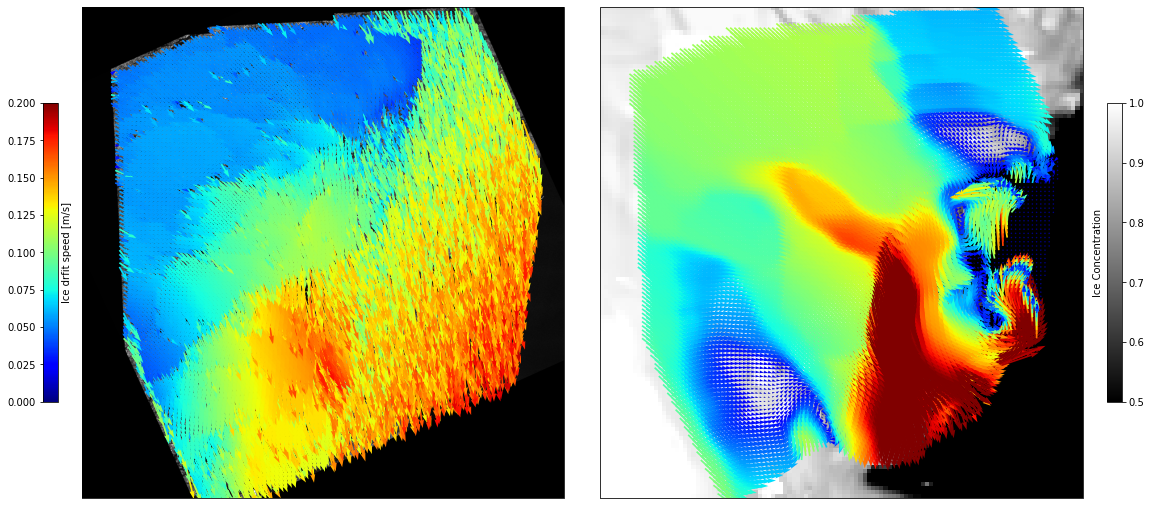

In [53]:
#dayssec = 24*60*60
dayssec = total_time_diff

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt((v**2+u**2)) 
# compute model ice drift speed [m/s]
delta_t = dayssec #in seconds
u_model = dx_mod / delta_t
v_model = dy_mod / delta_t
speed_model = np.sqrt((v_model**2+u_model**2)) 

gpi = (hpm > 0)#*(siconc_subset > 0.5)

# Combined data range
all_speeds = np.concatenate([speed[gpi], speed_model[gpi]])
vmin, vmax = np.min(all_speeds), np.max(all_speeds)
# Use this range to normalize both datasets
#norm = Normalize(vmin=vmin, vmax=vmax)
norm = Normalize(vmin=vmin, vmax=0.2)

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,11), subplot_kw={'projection': crs})

# Figure 1

ax1.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
# Overlay a semi-transparent gray layer
#gray_value = 0.9 # Midway between 0 (black) and 1 (white)
#rect = Rectangle((x1pm.min(), y1pm.min()), x1pm.max() - x1pm.min(), y1pm.max() - y1pm.min(), facecolor='black', alpha=0.4) #facecolor = str(gray_value)
#ax1.add_patch(rect)

# plot every n_th vector
#quiv1=ax1.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6],speed[gpi][::6], scale=2, cmap='jet',width=0.0035, norm = norm)
quiv1=ax1.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1],speed[gpi][::1], scale=2, cmap='jet',width=0.0035,  norm = norm) 
#quiv1=ax1.quiver(x1pm[::1], y1pm[::1], u[::1], v[::1],speed[::1], scale=2, cmap='jet',width=0.0035,  norm = norm) 
plt.quiverkey(quiv1, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
#plt.title('Ice drfit speed [m/s]')
ax1.add_feature(land_50m, edgecolor='black')
ax1.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax1.set_ylim([y1pm.min()+30000, y1pm.max()-60000])

#  Figure 2

# plot concentration
conc_img = ax2.imshow(siconc_subset, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='gray', alpha=1, vmin=0.5, vmax=1)
#plot every n_th vector
#quiv2 = ax2.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u_model[gpi][::6], v_model[gpi][::6], speed_model[gpi][::6], scale=2, cmap='jet', width=0.0035, norm=norm)
quiv2 = ax2.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u_model[gpi][::1], v_model[gpi][::1], speed_model[gpi][::1], scale=2, cmap='jet', width=0.0035, norm=norm)
#quiv2 = ax2.quiver(x1pm[::1], y1pm[::1], u_model[::1], v_model[::1], speed_model[::1], scale=2, cmap='jet', width=0.0035, norm=norm)
plt.quiverkey(quiv2, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
#plt.title('Ice drfit speed [m/s]')
ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax2.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
# colorbar for the concentration



#plt.colorbar(quiv1, ax=ax1, orientation='vertical', shrink=0.5)
cbar1 = plt.colorbar(quiv1,ax=ax1, label='Ice drfit speed [m/s]', location='left', shrink=0.5, pad=0.04)
cbar1.ax.yaxis.set_label_position('right')

cbar2 = plt.colorbar(conc_img, ax=ax2, label='Ice Concentration', location='right', shrink=0.5, pad=0.04)
cbar2.ax.yaxis.set_label_position('left')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.06)  


#plt.tight_layout()
plt.show()

##### Calculting error

In [55]:
ref_displacement = np.sqrt((upm**2+vpm**2))
model_displacement =  np.sqrt((dx_mod**2+dy_mod**2))

#average magnitude of errors between the reference and the model displacements
rmse = np.sqrt(np.nanmean((ref_displacement - model_displacement)**2))
rmse

6093.524475966157

In [59]:
# Root Mean Square Error
rmse = np.sqrt(np.nanmean((upm - dx_mod)**2))

# Absolute Error 
abs_error_dx = (upm - dx_mod)
abs_error_dy = (vpm - dy_mod)

# Relative Error (check for zeroes)
relative_error_dx = (upm - dx_mod)/upm
relative_error_dy = (vpm - dy_mod)/upm

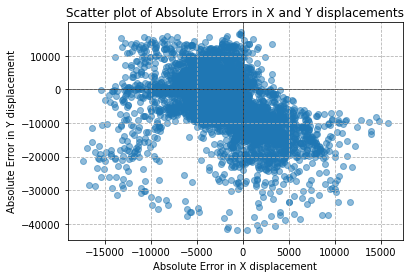

In [60]:
import matplotlib.pyplot as plt

plt.scatter(abs_error_dx, abs_error_dy, alpha=0.5)
plt.xlabel('Absolute Error in X displacement')
plt.ylabel('Absolute Error in Y displacement')
plt.title('Scatter plot of Absolute Errors in X and Y displacements')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(True, which="both", ls="--", c='0.7')
plt.show()

In [61]:
# compute total speed [m/s]

delta_t = total_time_diff #in seconds
u = dx_mod / delta_t
v = dy_mod / delta_t
speed_model = np.sqrt((v**2+u**2)) 


delta_t = total_time_diff #in seconds
u = upm / delta_t
v = vpm / delta_t
speed_ref = np.sqrt((v**2+u**2))

Reference Speeds:
Mean speed: 0.0977 m/s
Min speed: 0.0211 m/s
Max speed: 0.1890 m/s
95th percentile speed: 0.1549 m/s

Model Speeds:
Mean speed: 0.0976 m/s
Min speed: 0.0000 m/s
Max speed: 0.3201 m/s
95th percentile speed: 0.2138 m/s


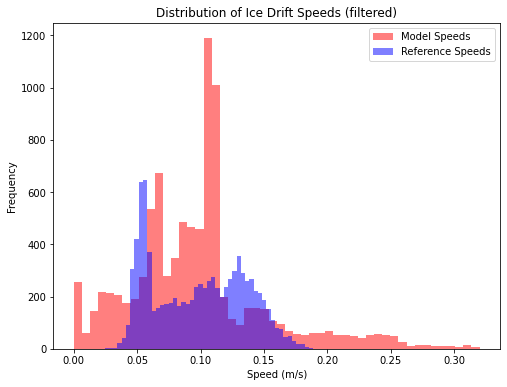

In [62]:
plt.figure(figsize=(8,6))


# Plotting Model Speed
plt.hist(speed_model[gpi], bins=50, color='red', alpha=0.5, label='Model Speeds')

# Plotting Reference Speed
plt.hist(speed_ref[gpi], bins=50, color='blue', alpha=0.5, label='Reference Speeds')

plt.xlabel('Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Ice Drift Speeds (filtered)')
plt.legend()
plt.show()

# Print statistics for reference speeds
percentile_95_ref = np.percentile(speed_ref[gpi], 95)
mean_speed_ref = np.nanmean(speed_ref[gpi])
min_speed_ref = np.nanmin(speed_ref[gpi])
max_speed_ref = np.nanmax(speed_ref[gpi])

print(f"Reference Speeds:")
print(f"Mean speed: {mean_speed_ref:.4f} m/s")
print(f"Min speed: {min_speed_ref:.4f} m/s")
print(f"Max speed: {max_speed_ref:.4f} m/s")
print(f"95th percentile speed: {percentile_95_ref:.4f} m/s")

# Print statistics for model speeds
percentile_95_model = np.percentile(speed_model[gpi], 95)
mean_speed_model = np.nanmean(speed_model[gpi])
min_speed_model = np.nanmin(speed_model[gpi])
max_speed_model = np.nanmax(speed_model[gpi])

print("\nModel Speeds:")
print(f"Mean speed: {mean_speed_model:.4f} m/s")
print(f"Min speed: {min_speed_model:.4f} m/s")
print(f"Max speed: {max_speed_model:.4f} m/s")
print(f"95th percentile speed: {percentile_95_model:.4f} m/s")


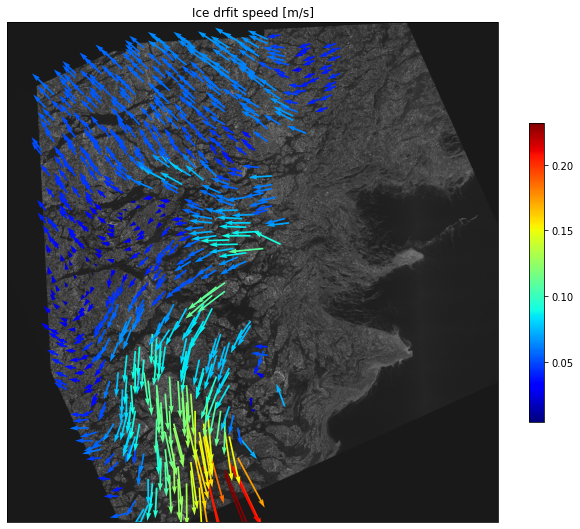

In [75]:
from matplotlib.patches import Rectangle

dayssec = total_time_diff

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = abs_error_dx / delta_t
v = abs_error_dy / delta_t
speed = np.sqrt((v**2+u**2)) 


# plot valid vectors in Polar stereographic projection
gpi = (hpm > 9)*(siconc_subset > 0.5)
# X/Y grids in polar stereographic projection covering image_1
#x1pm, y1pm = dom_pm.get_geolocation_grids(dst_srs=srs)
#x1pm, y1pm = d.get_geolocation_grids(pm_step, dst_srs=srs)


# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)


plt.figure(figsize=(11,11))
ax = plt.axes(projection=crs)


ax.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper') 
# Overlay a semi-transparent gray layer
gray_value = 0.2 # Midway between 0 (black) and 1 (white)
rect = Rectangle((x1pm.min(), y1pm.min()), x1pm.max() - x1pm.min(), y1pm.max() - y1pm.min(), facecolor=str(gray_value), alpha=0.5)
ax.add_patch(rect)
#plot every n_th vector
quiv=ax.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6],speed[gpi][::6], scale=1.5, cmap='jet',width=0.0035) #, 
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

#ax.set_xlim([x1pm.min(), x1pm.max()])
#ax.set_ylim([y1pm.min(), y1pm.max()])


ax.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
plt.show()

In [85]:
u_rel = relative_error_dx / delta_t
v_rel = relative_error_dy / delta_t
speed_rel = np.sqrt((u_rel**2+v_rel**2)) 

In [86]:
speed_rel

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [95]:
u_rel = relative_error_dx*100 / delta_t
v_rel = relative_error_dy*100 / delta_t
speed_rel = np.sqrt((u_rel**2+v_rel**2)) 

In [96]:
np.nanmin(speed_rel), np.nanmax(speed_rel)

(7.051177377346043e-05, 21.105487482646435)

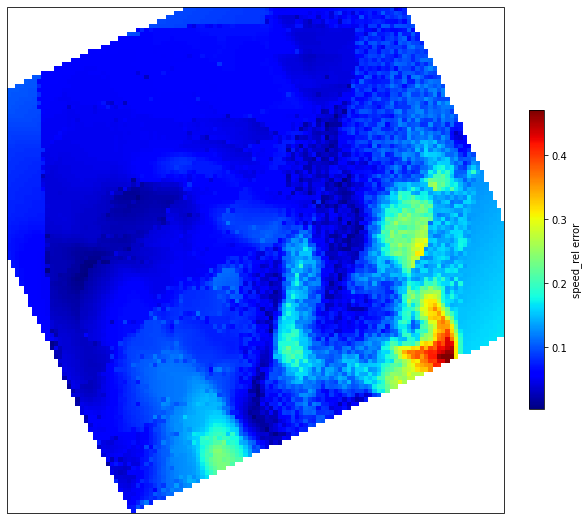

In [102]:
from matplotlib.patches import Rectangle


# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = abs_error_dx / delta_t
v = abs_error_dy / delta_t
speed = np.sqrt((v**2+u**2)) 



# plot valid vectors in Polar stereographic projection
gpi = (hpm > 9)*(siconc_subset > 0.5)
# X/Y grids in polar stereographic projection covering image_1
#x1pm, y1pm = dom_pm.get_geolocation_grids(dst_srs=srs)
#x1pm, y1pm = d.get_geolocation_grids(pm_step, dst_srs=srs)


# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)


plt.figure(figsize=(11,11))
ax = plt.axes(projection=crs)

speed = ax.imshow(speed, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='jet', alpha=1)

#ax.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper') 
# Overlay a semi-transparent gray layer
#gray_value = 0.2 # Midway between 0 (black) and 1 (white)
#rect = Rectangle((x1pm.min(), y1pm.min()), x1pm.max() - x1pm.min(), y1pm.max() - y1pm.min(), facecolor=str(gray_value), alpha=0.5)
#ax.add_patch(rect)
#plot every n_th vector
#quiv=ax.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6],speed[gpi][::6], scale=1.5, cmap='jet',width=0.0035) #, 
##plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
#plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

cbar = plt.colorbar(speed, ax=ax, label='speed_rel error', location='right', shrink=0.5, pad=0.04)
#cbar2.ax.yaxis.set_label_position('left')


ax.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
plt.show()